<a href="https://colab.research.google.com/github/zaenalSamsul/UAS_CHEST-X-RAY_PNEUMONIA_COVID-19/blob/main/Covid_19_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

## Path Direktori Dataset
BASE_DIR =  "/content/drive/MyDrive/Covid-19-Pneumonia-VGG16"
TRAIN_DIR = os.path.join(BASE_DIR, 'train/')
VAL_DIR = os.path.join(BASE_DIR, 'VAL/')
TEST_DIR = os.path.join(BASE_DIR, 'test/')
IMG_PATH = 'path_to_your_dataset/'  # Replace with your dataset directory
TRAIN_DIR = 'train/'
TEST_DIR = 'test/'

In [3]:
# Pastikan folder TRAIN, VAL, dan TEST ada
os.makedirs(os.path.join(TRAIN_DIR, 'PNEUMONIA'), exist_ok=True)
os.makedirs(os.path.join(TRAIN_DIR, 'NORMAL'), exist_ok=True)
os.makedirs(os.path.join(VAL_DIR, 'PNEUMONIA'), exist_ok=True)
os.makedirs(os.path.join(VAL_DIR, 'NORMAL'), exist_ok=True)
os.makedirs(os.path.join(TEST_DIR, 'PNEUMONIA'), exist_ok=True)
os.makedirs(os.path.join(TEST_DIR, 'NORMAL'), exist_ok=True)

In [4]:
# Fungsi untuk memindahkan data ke folder TRAIN, VAL, TEST
def split_data(base_path, train_dir, val_dir, test_dir):
    for label in ['PNEUMONIA', 'NORMAL']:
        img_paths = [
            os.path.join(base_path, label),
            os.path.join(base_path, 'Covid-19-Pneumonia-VGG16', label)
        ]
        for img_path in img_paths:
            if os.path.exists(img_path):
                img_files = os.listdir(img_path)
                total_images = len(img_files)
                for idx, img_file in enumerate(img_files):
                    src = os.path.join(img_path, img_file)
                    if idx < 0.1 * total_images:
                        dst = os.path.join(test_dir, label.upper(), img_file)
                    elif idx < 0.8 * total_images:
                        dst = os.path.join(train_dir, label.upper(), img_file)
                    else:
                        dst = os.path.join(val_dir, label.upper(), img_file)
                    shutil.copy(src, dst)

In [5]:
# Panggil fungsi untuk memindahkan data
split_data(BASE_DIR, TRAIN_DIR, VAL_DIR, TEST_DIR)

# Data Augmentation
IMG_SIZE = (150, 150)
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary'
)

validation_generator = datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary'
)

test_generator = datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 174 images belonging to 2 classes.
Found 46 images belonging to 2 classes.
Found 53 images belonging to 2 classes.


Training samples: 174
Validation samples: 46


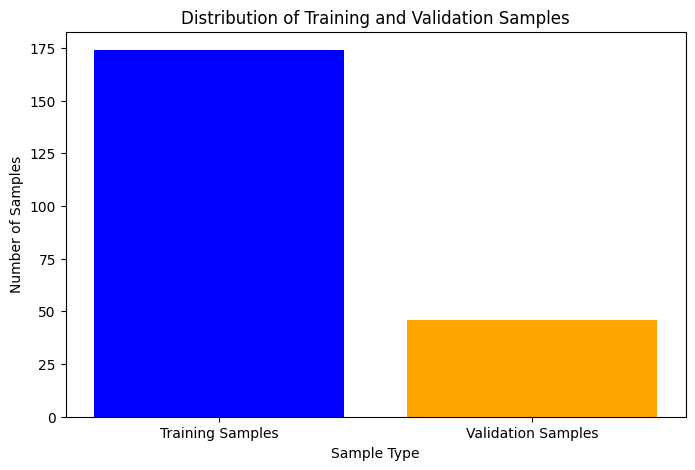

In [6]:
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")



# Visualisasi Data
labels = ['Training Samples', 'Validation Samples']
values = [train_generator.samples, validation_generator.samples]

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['blue', 'orange'])
plt.title('Distribution of Training and Validation Samples')
plt.xlabel('Sample Type')
plt.ylabel('Number of Samples')
plt.show()

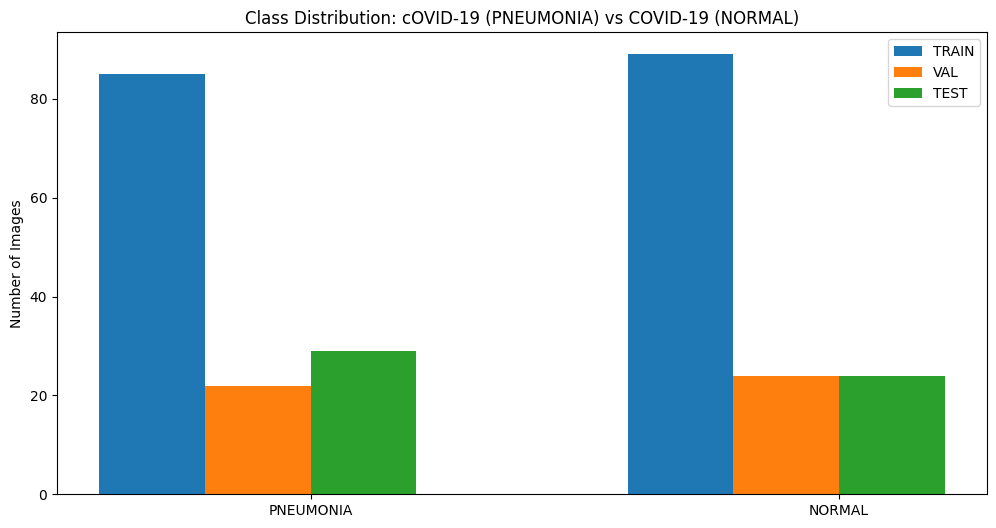

In [7]:
import os
import matplotlib.pyplot as plt

# Fungsi untuk menghitung jumlah file dalam setiap kategori
def count_images(directory):
    categories = ['PNEUMONIA', 'NORMAL']
    counts = {}
    for category in categories:
        path = os.path.join(directory, category)
        counts[category] = len(os.listdir(path))
    return counts

# Hitung distribusi data di TRAIN, VAL, dan TEST
train_counts = count_images(TRAIN_DIR)
val_counts = count_images(VAL_DIR)
test_counts = count_images(TEST_DIR)

# Gabungkan data untuk visualisasi
data = {
    "TRAIN": train_counts,
    "VAL": val_counts,
    "TEST": test_counts
}

# Visualisasi data
labels = ['PNEUMONIA', 'NORMAL']
x = range(len(labels))

plt.figure(figsize=(12, 6))
for i, (dataset, counts) in enumerate(data.items()):
    plt.bar([p + i * 0.2 for p in x], [counts[label] for label in labels], width=0.2, label=dataset)

plt.xticks([p + 0.3 for p in x], labels)
plt.ylabel("Number of Images")
plt.title("Class Distribution: cOVID-19 (PNEUMONIA) vs COVID-19 (NORMAL)")
plt.legend()
plt.show()


Sampel gambar kategori 'PNEUMONIA' (COVID-19):


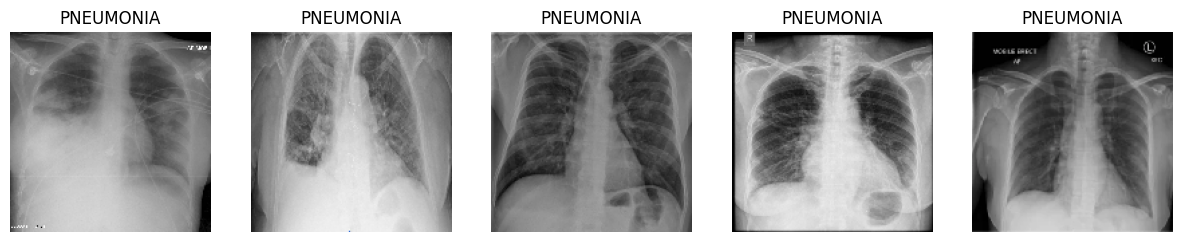

Sampel gambar kategori 'NORMAL' (No PNEUMONIA):


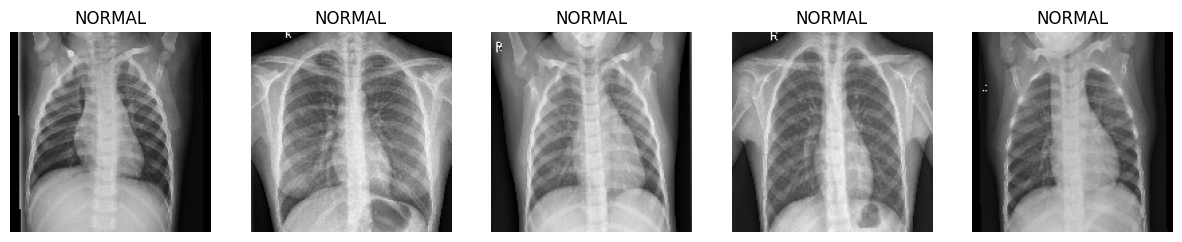

In [8]:
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def visualize_samples(directory, category, num_samples=5):
    """
    Menampilkan beberapa sampel gambar dari kategori tertentu di direktori dataset.
    Args:
        directory (str): Path direktori dataset (TRAIN, VAL, atau TEST).
        category (str): Kategori gambar ('YES' atau 'NO').
        num_samples (int): Jumlah sampel gambar yang ingin ditampilkan.
    """
    path = os.path.join(directory, category)
    images = os.listdir(path)[:num_samples]  # Ambil beberapa gambar
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(path, img_name)
        img = load_img(img_path, target_size=(150, 150))  # Resize ke ukuran yang digunakan dalam model
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')
    plt.show()

# Tampilkan sampel gambar dari kategori 'YES' dan 'NO' di TRAIN dataset
print("Sampel gambar kategori 'PNEUMONIA' (COVID-19):")
visualize_samples(TRAIN_DIR, 'PNEUMONIA', num_samples=5)

print("Sampel gambar kategori 'NORMAL' (No PNEUMONIA):")
visualize_samples(TRAIN_DIR, 'NORMAL', num_samples=5)


In [9]:
# Model CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load VGG16 tanpa fully connected layer
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze semua layer VGG16 agar tidak di-train ulang
for layer in vgg_base.layers:
    layer.trainable = False

# Tambahkan lapisan klasifikasi di atasnya
x = vgg_base.output
x = GlobalAveragePooling2D()(x)  # Pooling untuk mengurangi dimensi
x = Dense(256, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout untuk mencegah overfitting
output_layer = Dense(1, activation='sigmoid')(x)  # Klasifikasi binary




In [11]:
# Definisikan model yang benar
vgg_model = Model(inputs=vgg_base.input, outputs=output_layer)

In [12]:

# Compile model
#vgg_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [14]:
# Unfreeze beberapa layer terakhir dari VGG16 untuk fine-tuning
for layer in vgg_base.layers[-4:]:  # Membuka 4 layer terakhir agar bisa dilatih
    layer.trainable = True

# Compile ulang model setelah fine-tuning
vgg_model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Training ulang dengan fine-tuning
EPOCHS = 20
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=6)
history_finetune = vgg_model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[es]  # Early stopping
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 83s 13s/step - accuracy: 0.5229 - loss: 0.7056 - val_accuracy: 0.6087 - val_loss: 0.6412
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 86s 13s/step - accuracy: 0.6469 - loss: 0.6587 - val_accuracy: 0.8913 - val_loss: 0.5867
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 82s 13s/step - accuracy: 0.6886 - loss: 0.5943 - val_accuracy: 0.9565 - val_loss: 0.5286
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 76s 12s/step - accuracy: 0.6421 - loss: 0.6429 - val_accuracy: 0.9783 - val_loss: 0.4702
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 82s 12s/step - accuracy: 0.7817 - loss: 0.5008 - val_accuracy: 0.9783 - val_loss: 0.4106
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 82s 13s/step - accuracy: 0.9193 - loss: 0.4105 - val_accuracy: 0.9565 - val_loss: 0.3626
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 82s 12s/step - accuracy: 0.9074 - loss: 0.3532 - val_accuracy: 0.9565 - val_loss: 0.3071
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 72s 13s/step - accuracy: 0.9437 - loss: 0.2985 - val_accuracy: 0.9783 - val_loss: 0.2534
Epoch 9/20


In [ ]:
# Training Model
#EPOCHS = 30
#es = EarlyStopping(monitor='val_accuracy', mode='max', patience=6)

#history_vgg = vgg_model.fit(
 #   train_generator,
  #  epochs=EPOCHS,
   # validation_data=validation_generator,
    #callbacks=[es]
#)



2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step


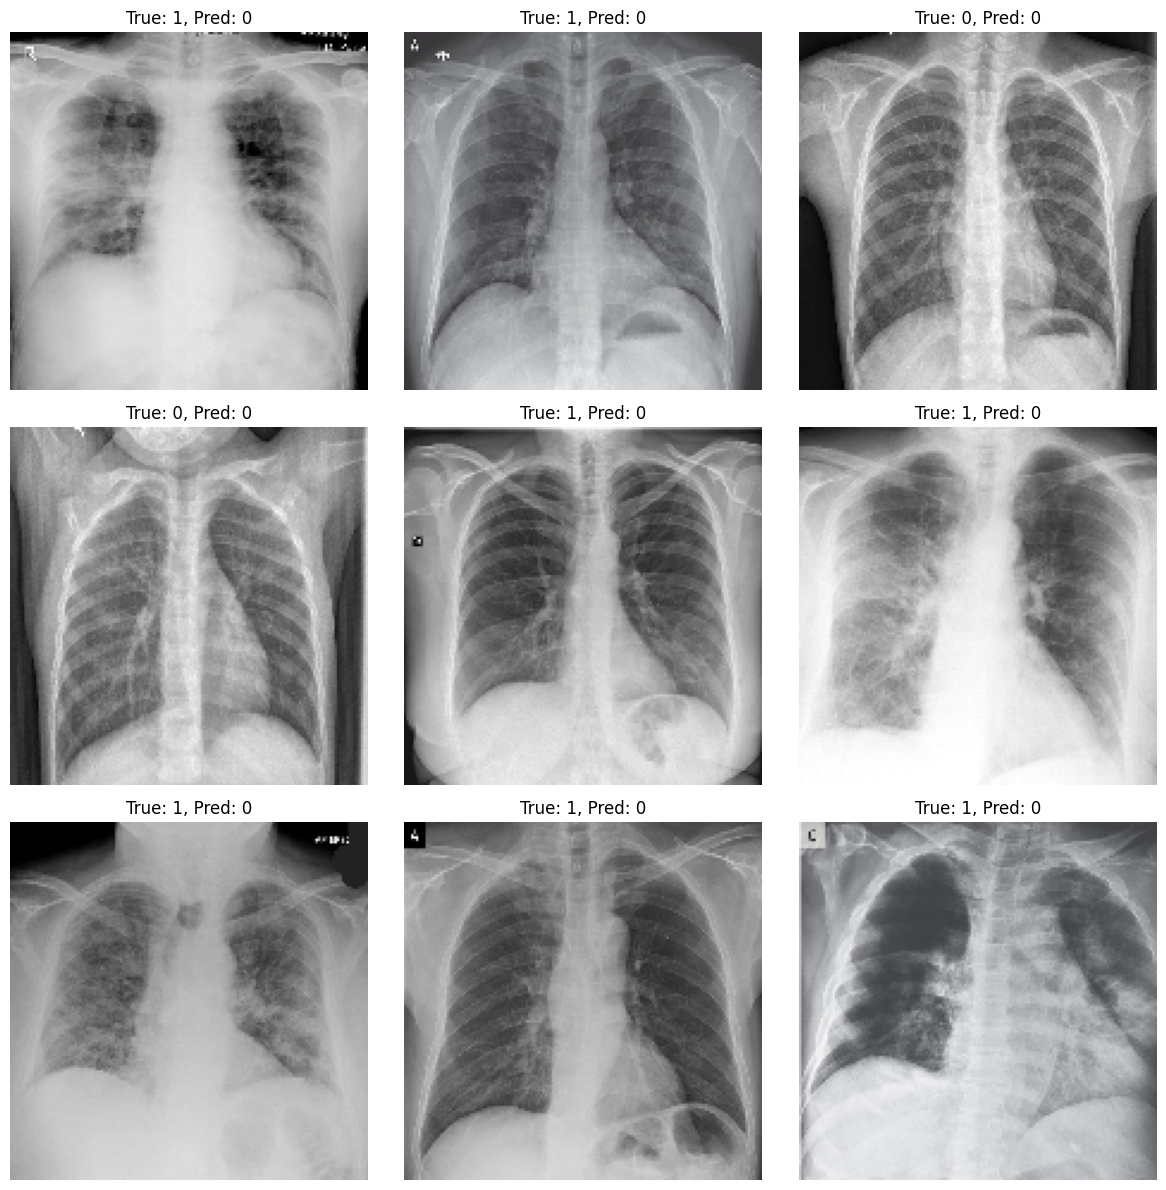

In [15]:
import random
import numpy as np
import matplotlib.pyplot as plt

def plot_predictions(generator, predictions, true_labels, num_images=9):
    # Ambil semua gambar dan label dari generator
    all_data = []
    all_labels = []

    # Reset generator
    generator.reset()

    # Iterasi untuk mengambil semua batch
    for _ in range(len(generator)):
        data, labels = next(generator)
        all_data.append(data)
        all_labels.extend(labels)

    # Gabungkan semua batch menjadi satu array
    all_data = np.concatenate(all_data, axis=0)
    all_labels = np.array(all_labels)

    # Jika gambar dinormalisasi, denormalisasi ke rentang [0, 255]
    if all_data.max() <= 1.0:
        all_data = (all_data * 255).astype("uint8")

    # Ambil subset dari seluruh data untuk plot
    indices = random.sample(range(len(all_data)), min(num_images, len(all_data)))
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    for i, ax in enumerate(axes.flatten()):
        if i >= len(indices):
            break
        idx = indices[i]
        ax.imshow(all_data[idx])  # Gambar dalam uint8 sudah siap ditampilkan
        ax.set_title(f"True: {true_labels[idx]}, Pred: {predictions[idx]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Contoh penggunaan
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

plot_predictions(test_generator, y_pred_classes, test_generator.classes)


In [16]:
# Fungsi Evaluasi Model
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def evaluate_model(generator, model, labels):
    generator.reset()  # Reset generator agar evaluasi dimulai dari awal
    predictions = model.predict(generator, steps=len(generator), verbose=1)
    predictions = [1 if x > 0.5 else 0 for x in predictions]  # Konversi probabilitas ke label biner

    true_labels = generator.classes  # Label sebenarnya dari data
    accuracy = accuracy_score(true_labels, predictions)
    print(f'Accuracy = {accuracy:.2f}')

    # Plot Confusion Matrix
    confusion_mtx = confusion_matrix(true_labels, predictions)
    plt.matshow(confusion_mtx, cmap='Blues')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(ticks=[0, 1], labels=labels)
    plt.yticks(ticks=[0, 1], labels=labels)
    plt.show()


Validation Performance:
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step
Accuracy = 0.63


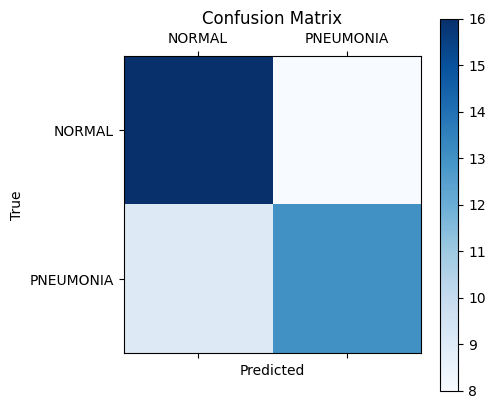

Test Performance:
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step
Accuracy = 0.94


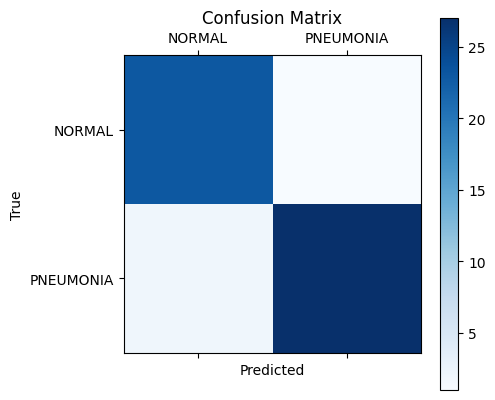

In [17]:
# Evaluasi Model
print("Validation Performance:")
evaluate_model(validation_generator, vgg_model, labels=['NORMAL', 'PNEUMONIA'])
print("Test Performance:")
evaluate_model(test_generator, vgg_model, labels=['NORMAL', 'PNEUMONIA'])

2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 6s/step


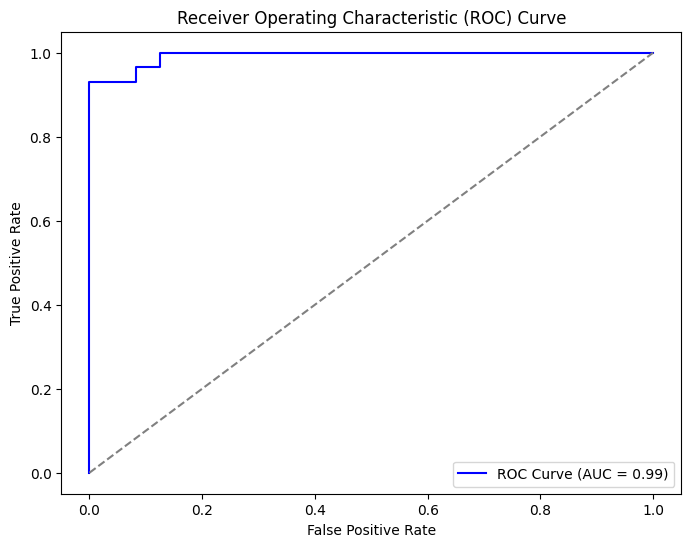

In [19]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Evaluasi pada test set
y_pred_proba = vgg_model.predict(test_generator)  # Probabilitas kelas positif
y_true = test_generator.classes  # Label asli

# Hitung ROC-AUC
roc_auc = roc_auc_score(y_true, y_pred_proba)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Garis diagonal sebagai baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()


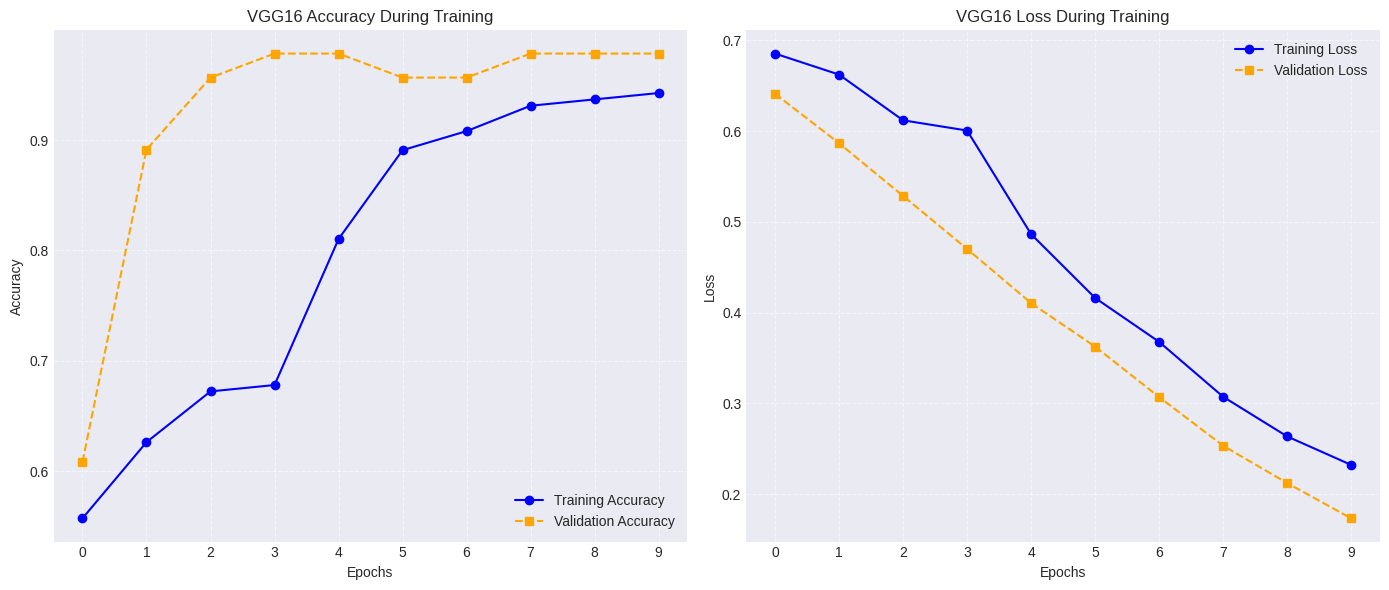

In [22]:
import matplotlib.pyplot as plt

# Menggunakan gaya seaborn untuk tampilan lebih rapi
plt.style.use('seaborn-v0_8-darkgrid')

# Membuat figure dengan ukuran lebih besar
plt.figure(figsize=(14, 6))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['accuracy'], marker='o', linestyle='-', label='Training Accuracy', color='blue')
plt.plot(history_finetune.history['val_accuracy'], marker='s', linestyle='--', label='Validation Accuracy', color='orange')
plt.title('VGG16 Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(len(history_finetune.history['accuracy'])))  # Menampilkan setiap epoch di sumbu X
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['loss'], marker='o', linestyle='-', label='Training Loss', color='blue')
plt.plot(history_finetune.history['val_loss'], marker='s', linestyle='--', label='Validation Loss', color='orange')
plt.title('VGG16 Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(len(history_finetune.history['loss'])))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right')

# Layout yang lebih rapi
plt.tight_layout()
plt.show()


Saving IM-0001-0001.jpeg to IM-0001-0001.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step


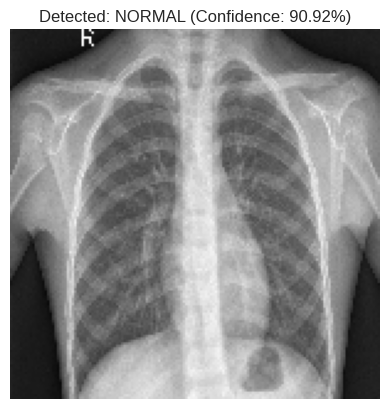

Gambar: IM-0001-0001.jpeg
Prediksi: NORMAL
Akurasi Model: 90.92%


In [24]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Unggah gambar
uploaded = files.upload()

# Load model yang sudah dilatih
model = vgg_model  # Gunakan model VGG16 yang sudah dilatih sebelumnya

# Parameter input gambar
IMG_SIZE = (150, 150)

for filename in uploaded.keys():
    # Load dan preprocess gambar
    img_path = filename
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan batch dimension
    img_array = img_array / 255.0  # Normalisasi

    # Prediksi dengan model
    prediction = model.predict(img_array)
    probability = prediction[0][0]  # Probabilitas kelas pneumonia

    # Tentukan label berdasarkan threshold 0.5
    label = "PNEUMONIA" if probability > 0.5 else "NORMAL"
    confidence = max(probability, 1 - probability) * 100  # Konversi ke persentase

    # Tampilkan gambar
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Detected: {label} (Confidence: {confidence:.2f}%)")
    plt.show()

    print(f"Gambar: {filename}")
    print(f"Prediksi: {label}")
    print(f"Akurasi Model: {confidence:.2f}%")


Saving Pneumonia Test1.jpeg to Pneumonia Test1.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


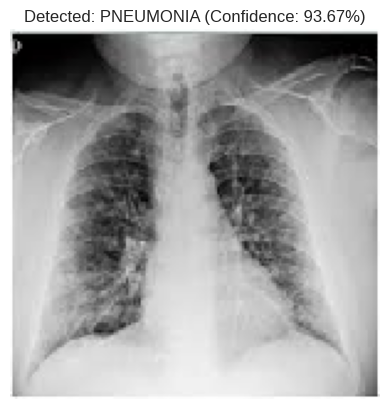

Gambar: Pneumonia Test1.jpeg
Prediksi: PNEUMONIA
Akurasi Model: 93.67%


In [25]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Unggah gambar
uploaded = files.upload()

# Load model yang sudah dilatih
model = vgg_model  # Gunakan model VGG16 yang sudah dilatih sebelumnya

# Parameter input gambar
IMG_SIZE = (150, 150)

for filename in uploaded.keys():
    # Load dan preprocess gambar
    img_path = filename
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan batch dimension
    img_array = img_array / 255.0  # Normalisasi

    # Prediksi dengan model
    prediction = model.predict(img_array)
    probability = prediction[0][0]  # Probabilitas kelas pneumonia

    # Tentukan label berdasarkan threshold 0.5
    label = "PNEUMONIA" if probability > 0.5 else "NORMAL"
    confidence = max(probability, 1 - probability) * 100  # Konversi ke persentase

    # Tampilkan gambar
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Detected: {label} (Confidence: {confidence:.2f}%)")
    plt.show()

    print(f"Gambar: {filename}")
    print(f"Prediksi: {label}")
    print(f"Akurasi Model: {confidence:.2f}%")
